# Neural Network Architecture Optimization with Optuna

## 📊 Project Overview

This notebook demonstrates **automated neural network architecture search** using Optuna for depression prediction. Instead of manually trying different network configurations, we use **hyperparameter optimization** to discover the best architecture.

### Problem Statement
Predict depression risk based on personal, academic, and professional factors using a **deep learning approach**.

### Automated Architecture Search

Traditional approach:
```
Try 3 layers → Test → Try 5 layers → Test → Try different activations → Test...
(Manual, slow, suboptimal)
```

Our approach with Optuna:
```
Define search space → Optuna tries 100 configurations → Best architecture found
(Automated, efficient, optimal)
```

### What We Optimize

**Architecture Components:**
- Number of hidden layers (1-5)
- Units per layer (32-512)
- Activation functions (ReLU, Tanh, ELU)
- Dropout rates (0.0-0.5)
- Batch normalization (Yes/No)
- Learning rate (0.0001-0.01)
- Optimizer (Adam, RMSprop, SGD)
- Batch size (16-128)

**Search Space**: Billions of possible combinations!

### Workflow
1. **Data Loading & Preprocessing**: Same as previous notebooks
2. **Feature Engineering**: Create predictive features
3. **Architecture Search**: Optuna finds optimal configuration
4. **Model Training**: Train best model with K-Fold CV
5. **Evaluation**: Analyze loss curves and performance

---


#### <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:140%; font-family:Arial, sans-serif; background-color:#1C76B6; color:#ffffff; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> In this notebook, I demonstrate how to leverage Optuna, a hyperparameter optimization framework, to find the best architecture for an Artificial Neural Network (ANN) model for a given task</br></br>The goal is to optimize various architectural components of the ANN, such as the number of layers, number of neurons per layer, dropout rates, and more, treating each component as a hyperparameter to be tuned. </b></div>

## 📦 Library Imports

**Deep Learning:**
- `tensorflow/keras`: Neural network construction and training
- `plot_model`: Visualize network architecture

**Machine Learning:**
- `sklearn`: Preprocessing, cross-validation, metrics
- `category_encoders`: Target encoding for categorical features

**Optimization:**
- `optuna`: Automated hyperparameter/architecture search

**Data & Visualization:**
- `numpy`, `pandas`: Data manipulation
- `matplotlib`, `seaborn`: Visualization

**Why Neural Networks for This Task?**
- Can learn **complex non-linear patterns**
- **Feature interactions** captured automatically
- Potentially higher performance ceiling than tree-based models
- Good for **tabular data** with many categorical features (when properly encoded)


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer

from category_encoders import TargetEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import plot_model

import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:140%; font-family:Arial, sans-serif; background-color:#1C76B6; color:#ffffff; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 1. Load Dataset </b></div>

In [2]:
competition = pd.read_csv('/kaggle/input/playground-series-s4e11/train.csv').drop(columns='id')
original = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e11/test.csv').drop(columns='id')

In [3]:
competition.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
original.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


In [5]:
test.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
0,Shivam,Male,53.0,Visakhapatnam,Working Professional,Judge,NaN,2.0,NaN,NaN,5.0,Less than 5 hours,Moderate,LLB,No,9.0,3.0,Yes
1,Sanya,Female,58.0,Kolkata,Working Professional,Educational Consultant,NaN,2.0,NaN,NaN,4.0,Less than 5 hours,Moderate,B.Ed,No,6.0,4.0,No
2,Yash,Male,53.0,Jaipur,Working Professional,Teacher,NaN,4.0,NaN,NaN,1.0,7-8 hours,Moderate,B.Arch,Yes,12.0,4.0,No
3,Nalini,Female,23.0,Rajkot,Student,NaN,5.0,NaN,6.84,1.0,NaN,More than 8 hours,Moderate,BSc,Yes,10.0,4.0,No
4,Shaurya,Male,47.0,Kalyan,Working Professional,Teacher,NaN,5.0,NaN,NaN,5.0,7-8 hours,Moderate,BCA,Yes,3.0,4.0,No


In [6]:
## Encoding Yes as 1 in original data to match the representation of competition data
original["Depression"] = (original["Depression"] == "Yes").astype("int")

In [7]:
original['source'] = 'original'
competition['source'] = 'competition'

In [8]:
## combining the original and competition data for this task

df_combined=pd.concat([competition, original])
df_combined=df_combined.drop_duplicates()

In [9]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143256 entries, 0 to 2555
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Name                                   143256 non-null  object 
 1   Gender                                 143256 non-null  object 
 2   Age                                    143256 non-null  float64
 3   City                                   143256 non-null  object 
 4   Working Professional or Student        143256 non-null  object 
 5   Profession                             105953 non-null  object 
 6   Academic Pressure                      28399 non-null   float64
 7   Work Pressure                          114836 non-null  float64
 8   CGPA                                   28400 non-null   float64
 9   Study Satisfaction                     28399 non-null   float64
 10  Job Satisfaction                       114844 non-null  float64

In [10]:
## reformating the columns names to remove spaces and special characters

df_combined=df_combined.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test=test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [11]:
## processing all strings in the dataset to remove training and leading whitespaces
## and to convert all strings to lowercase

cat_cols = df_combined.dtypes[df_combined.dtypes == 'object'].index.to_list()
df_combined[cat_cols] = df_combined[cat_cols].apply(lambda x: x.str.strip().str.lower())

In [12]:
test_cat_cols = test.dtypes[test.dtypes == 'object'].index.to_list()
test[test_cat_cols] = test[test_cat_cols].apply(lambda x: x.str.strip().str.lower())

**Observations:**



* There are many missing values in the dataset. We will have to do some heavy preprocessing to make the dataset usable!


# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:140%; font-family:Arial, sans-serif; background-color:#1C76B6; color:#ffffff; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 2. EDA </b></div>

In [13]:
def create_bivariate_plots_numerical(df, target_column):

    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if target_column in numerical_cols:
        numerical_cols.remove(target_column)

    # setting up the matplotlib figure
    n_rows = len(numerical_cols)  # One row for each numerical column
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 3))

    # creating bivariate plots
    for i, col in enumerate(numerical_cols):
        
        # Create a histogram
        sns.histplot(data=df, x=col, hue=target_column, ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'{col}')
        
        # Create a boxplot beside the histogram
        sns.boxplot(data=df, y=col, x=target_column, ax=axes[i, 1])
        axes[i, 1].set_title(f'{col}')

    plt.tight_layout()
    plt.show()

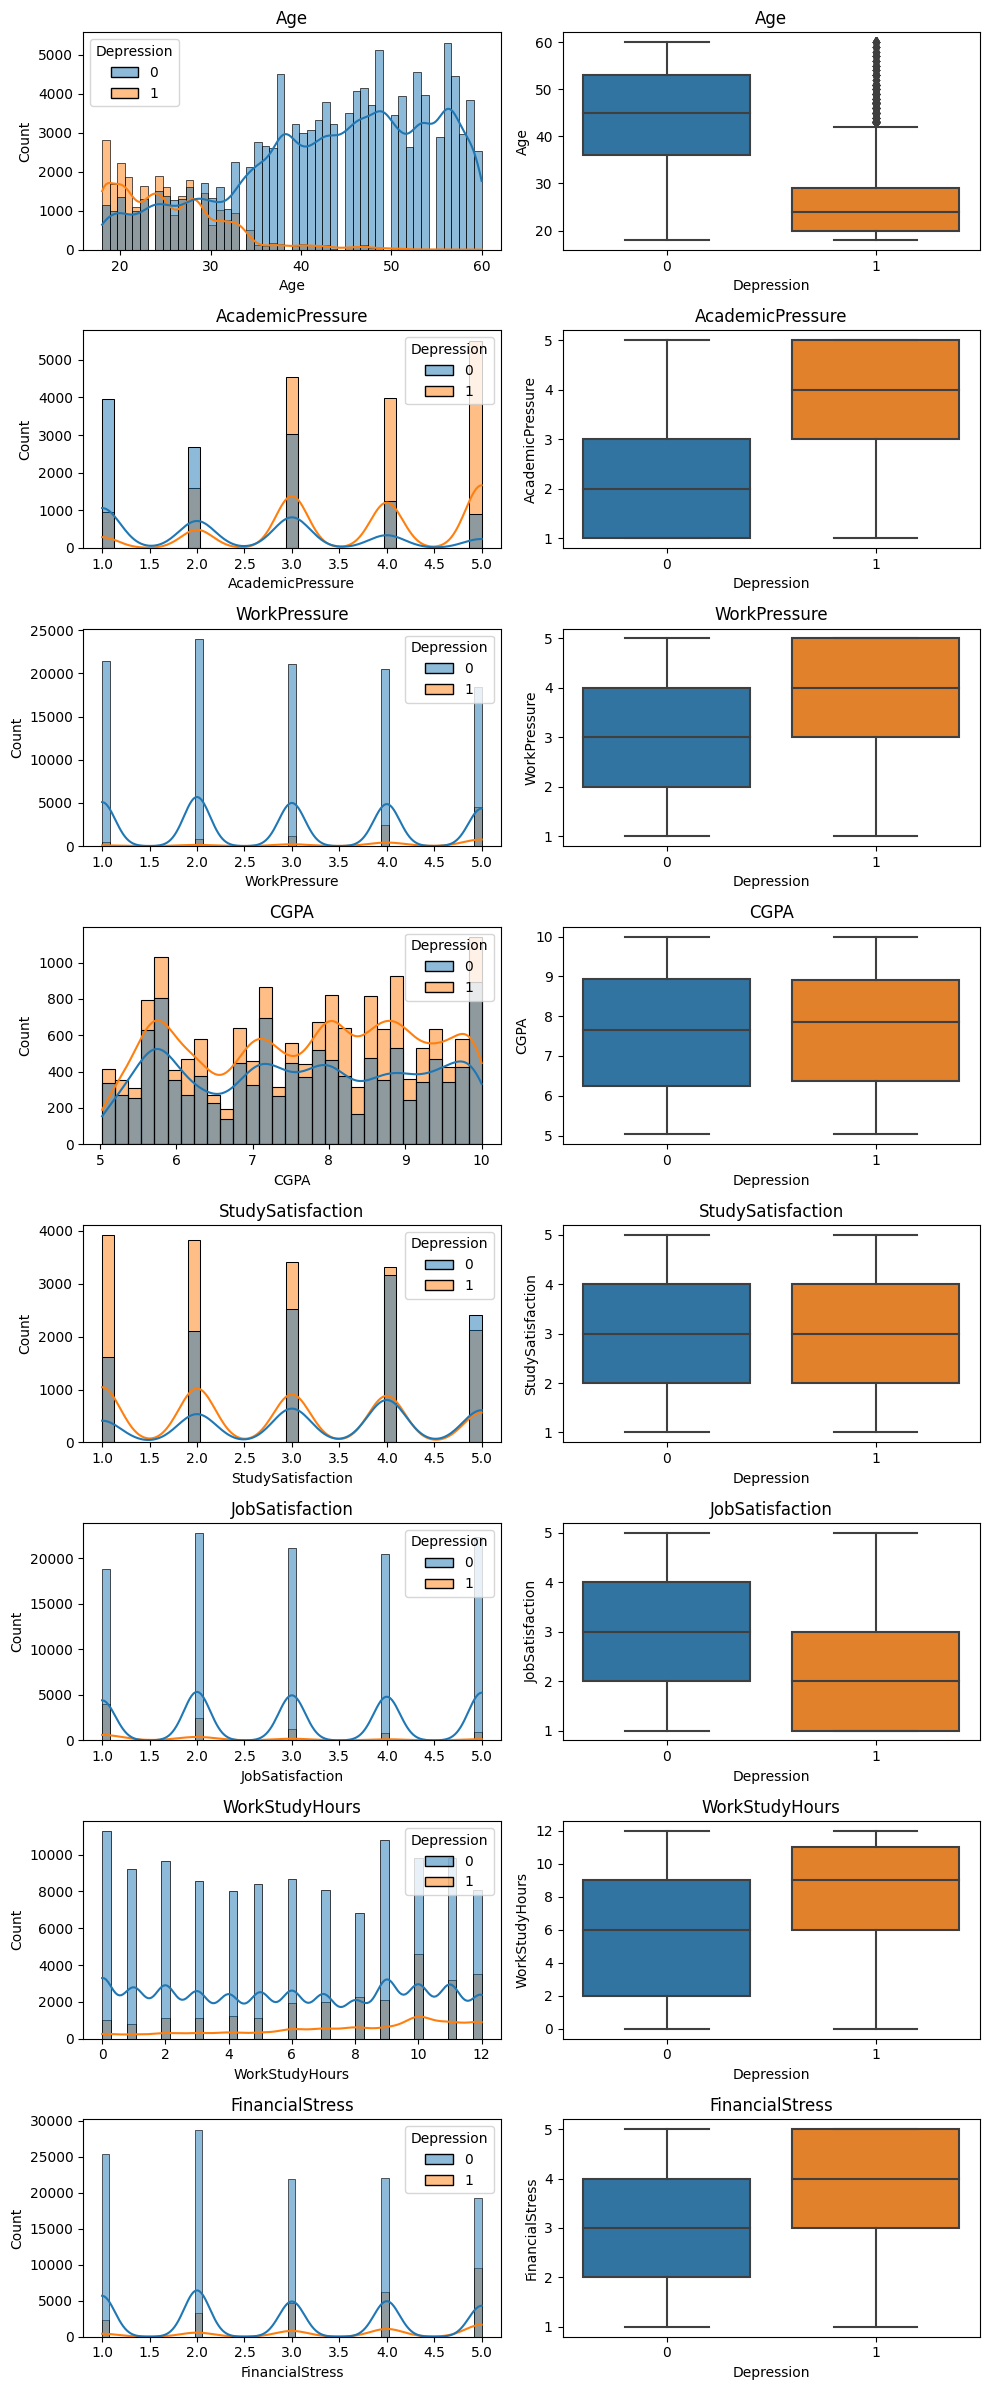

In [14]:
create_bivariate_plots_numerical(df_combined.reset_index(drop=True), 'Depression')

In [15]:
def create_bivariate_plots_categorical(df, target_column):

    # selecting categorical column names
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if target_column in categorical_cols:
        categorical_cols.remove(target_column)

    # setting up the matplotlib figure
    n_rows = int(np.ceil(len(categorical_cols)/2))  # One row for each numerical column
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 4))
    
    # flatten the axes array for easy iteration
    axes = axes.flatten()
    for i, col in enumerate(categorical_cols):
        # calculating the percentage of positive target variable for each category
        percentage_df = df.groupby(col)[target_column].mean().sort_values().reset_index()
        percentage_df[target_column] = percentage_df[target_column] * 100  # convert to percentage

        # creating bar plots
        sns.barplot(data=percentage_df, x=col, y=target_column, ax = axes[i], palette='viridis')
        axes[i].set_title(f'Percentage Depression by {col}')
        axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_ylabel(f'Depression %')
    plt.tight_layout()
    plt.show()

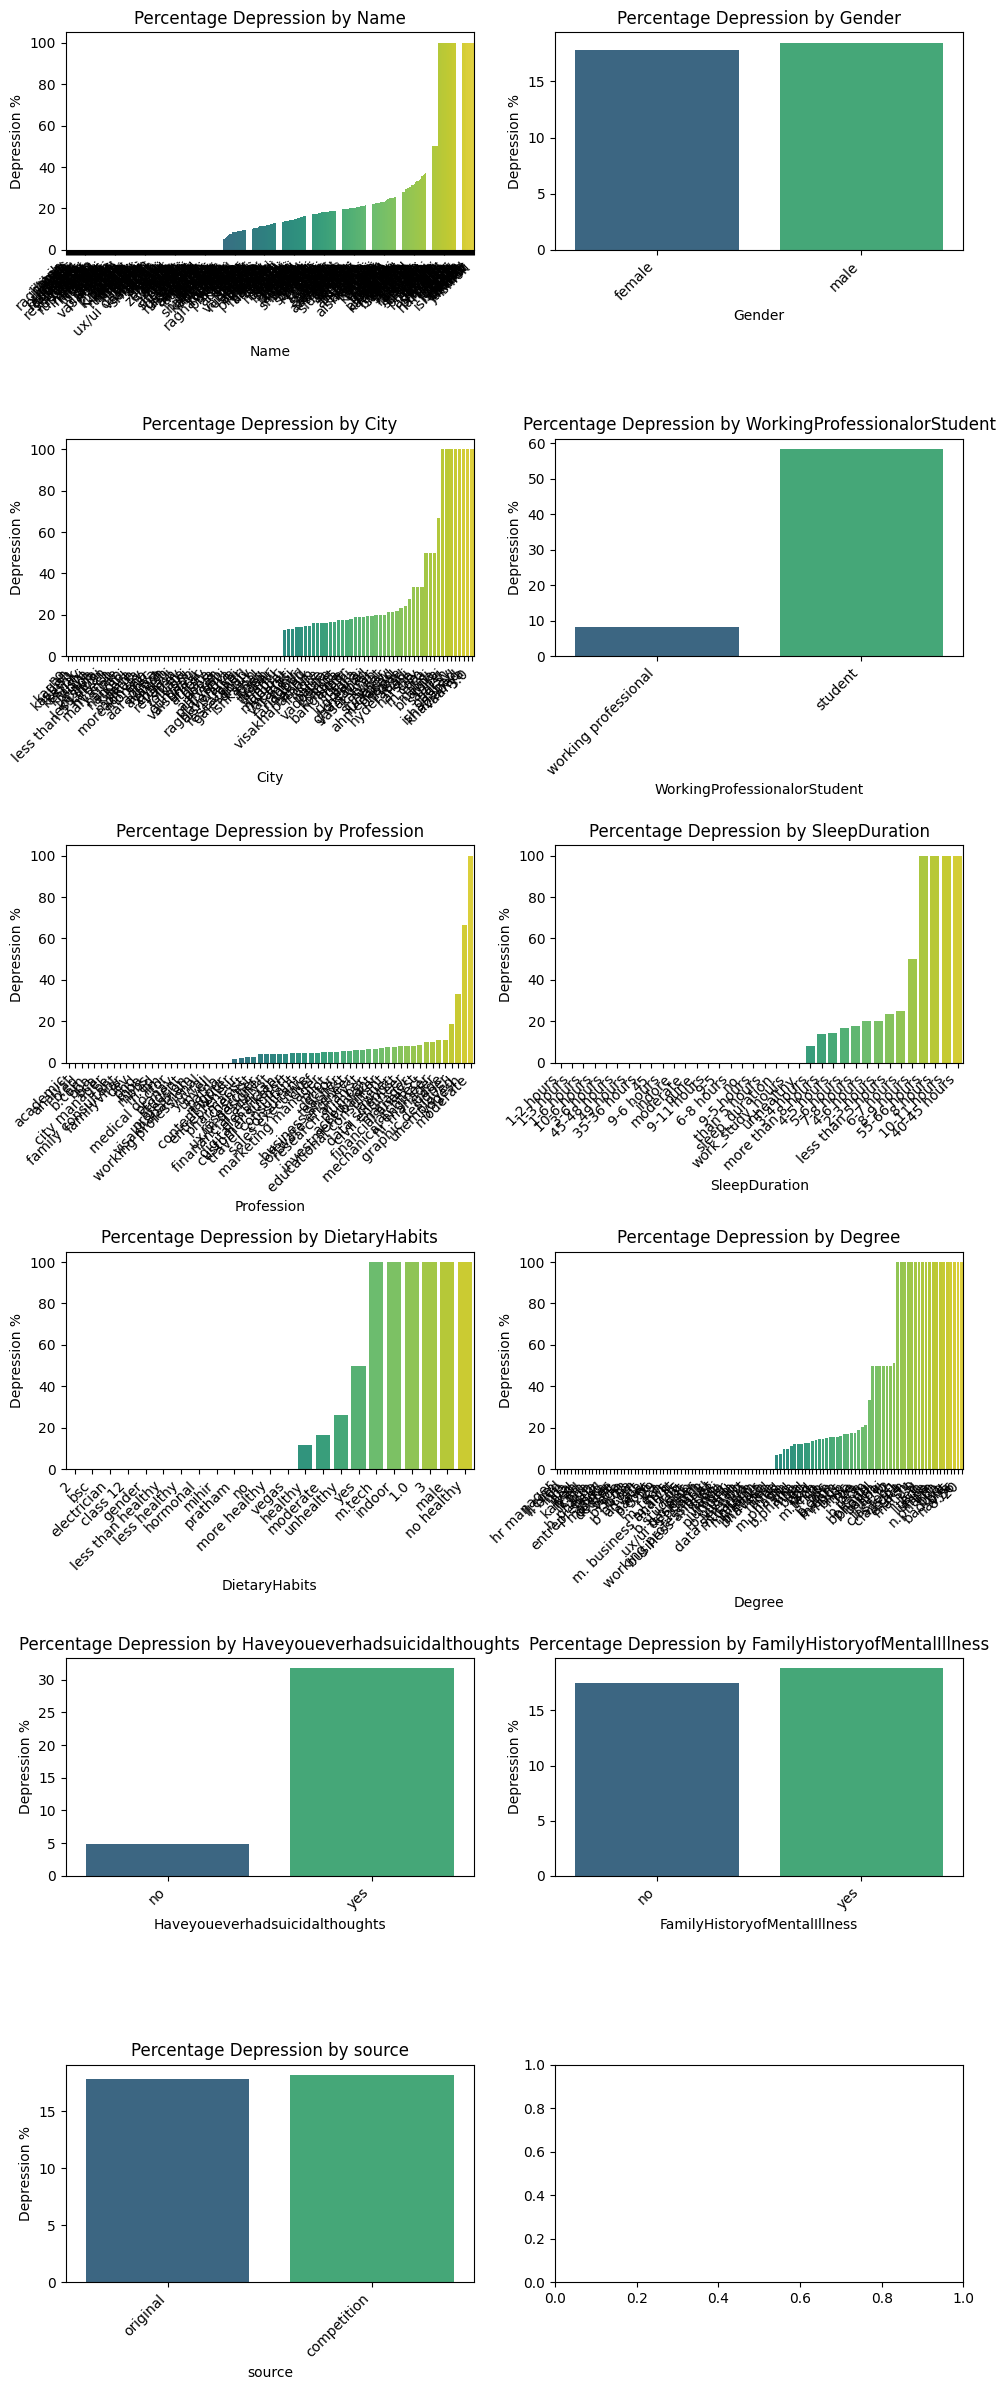

In [16]:
create_bivariate_plots_categorical(df_combined.reset_index(drop=True), 'Depression')

**Observations**

The following fields seem to have relatively stronger correlation with Depression:
* Age : Younger people are more likely to be depressed
* WorkPressure
* AcademicPressure
* WorkStudyHours
* FinancialStress
* JobSatisfaction
* StudySatisfaction
* WorkingProfessional or Student : Students are more likely to be depressed

Furthermore,  
* Some professions seem to have higer depression rate
* Some cities seem to have higer depression rate
  

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:140%; font-family:Arial, sans-serif; background-color:#1C76B6; color:#ffffff; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 3. Preprocessing and Feature Engineering </b></div> 

In [17]:
pd.set_option('display.max_rows', 250)

In [18]:
def compare_frequencies(df_combined, groupby_col, df_test=None, target = "Depression", top_n = 50):
    
    df1 = df_combined.groupby(groupby_col)[target].agg(['mean', 'count']).sort_values(by='count', ascending = False)[0:top_n]
    
    if df_test is None:
        return df1

    else:
        df2 = test.groupby(groupby_col).size().rename('count')
        df3 = pd.merge(df1, df2, how="left", left_index=True, right_index = True, suffixes = ('_train', '_test'))
        return df3

## 3.1 Processing Profession

In [19]:
## looking at the most frequent professions in the training and test data

df_profession = compare_frequencies(df_combined, "Profession", test)
df_profession

,mean,count_train,count_test
Profession,,,
teacher,0.056049,25228,16385.0
content writer,0.018916,7930,5187.0
architect,0.099482,4443,2982.0
consultant,0.047431,4301,2920.0
hr manager,0.107647,4106,2601.0
pharmacist,0.026462,3968,2656.0
doctor,0.052996,3321,2198.0
business analyst,0.057240,3232,2186.0
entrepreneur,0.020785,3031,1935.0


**Observation**
* It can be clearly seen that all the professions after 'investment banker' are extremely infrequent and can be considered as just noise.

* **We will remove these noisy and infrequent professions.**

In [20]:
## keeping only the professions that have at least 50 occurances in the train data

profession_features = df_profession[df_profession.count_train > 50].index.to_list()
print(profession_features)

['teacher', 'content writer', 'architect', 'consultant', 'hr manager', 'pharmacist', 'doctor', 'business analyst', 'entrepreneur', 'chemist', 'chef', 'educational consultant', 'data scientist', 'researcher', 'lawyer', 'customer support', 'marketing manager', 'pilot', 'travel consultant', 'plumber', 'manager', 'sales executive', 'judge', 'electrician', 'financial analyst', 'software engineer', 'civil engineer', 'ux/ui designer', 'digital marketer', 'finanancial analyst', 'accountant', 'mechanical engineer', 'graphic designer', 'research analyst', 'investment banker']


In [21]:
#df_combined['Profession'].replace('finanancial analyst', 'financial analyst', inplace = True)
df_combined['Profession']=df_combined['Profession'].apply(lambda x: x if x in profession_features else np.nan)

In [22]:
#test['Profession'].replace('finanancial analyst', 'financial analyst', inplace = True)
test['Profession']=test['Profession'].apply(lambda x: x if x in profession_features else np.nan)

In [23]:
df_combined['Profession'].value_counts(dropna=False)

Profession
NaN                       37353
teacher                   25228
content writer             7930
architect                  4443
consultant                 4301
hr manager                 4106
pharmacist                 3968
doctor                     3321
business analyst           3232
entrepreneur               3031
chemist                    3026
chef                       2921
educational consultant     2896
data scientist             2432
researcher                 2373
lawyer                     2260
customer support           2096
marketing manager          2015
pilot                      1952
travel consultant          1906
plumber                    1783
manager                    1779
sales executive            1771
judge                      1754
electrician                1615
financial analyst          1610
software engineer          1544
civil engineer             1501
ux/ui designer             1478
digital marketer           1403
finanancial analyst        13


**There are other columns in the dataset that need processing similar to Profession column.Therefore, we will define a function to make this processing a bit easier:**


In [24]:
def keep_desired_features(series_combined, series_test, desired_features, replace_value = np.nan):
    series_combined = series_combined.apply(lambda x: x if x in desired_features else replace_value)
    series_test = series_test.apply(lambda x: x if x in desired_features else replace_value)
    
    return series_combined, series_test

## 3.2 Processing Name

In [25]:
df_name = compare_frequencies(df_combined, "Name", test, top_n=250)
df_name

,mean,count_train,count_test
Name,,,
rohan,0.140137,3204,2112.0
aarav,0.228644,2353,1499.0
rupak,0.163470,2190,1434.0
aaradhya,0.196021,2061,1423.0
anvi,0.180136,2054,1398.0
raghavendra,0.084701,1889,1305.0
vani,0.168157,1677,1100.0
tushar,0.132552,1622,1173.0
ritvik,0.228607,1601,1033.0


In [26]:
name_features = df_name[df_name.count_train > 50].index.to_list()
df_combined['Name_processed'], test['Name_processed'] = keep_desired_features(df_combined['Name'], test['Name'], name_features)

## 3.3 Processing City

In [27]:
df_city = compare_frequencies(df_combined, "City", test)
df_city

,mean,count_train,count_test
City,,,
kalyan,0.199162,6683,4387.0
patna,0.163479,6013,3888.0
vasai-virar,0.198294,5860,3897.0
kolkata,0.173996,5776,3726.0
ahmedabad,0.217704,5705,3677.0
meerut,0.134127,5629,3661.0
ludhiana,0.192322,5314,3545.0
pune,0.161266,5308,3318.0
rajkot,0.173298,5303,3450.0


In [28]:
city_features = df_city[df_city.count_train > 50].index.to_list()
df_combined['City'], test['City'] = keep_desired_features(df_combined['City'], test['City'], city_features)

## 3.4 Processing Sleep Duration

In [29]:
df_sleep = compare_frequencies(df_combined, "SleepDuration", test)
df_sleep

,mean,count_train,count_test
SleepDuration,,,
less than 5 hours,0.234378,39432,25661.0
7-8 hours,0.178250,37627,24491.0
more than 8 hours,0.138839,33348,22190.0
5-6 hours,0.165731,32770,21404.0
3-4 hours,0.083333,12,3.0
6-7 hours,0.250000,8,7.0
4-5 hours,0.142857,7,6.0
4-6 hours,0.200000,5,2.0
2-3 hours,0.200000,5,4.0


In [30]:
sleep_features = df_sleep[df_sleep.count_train > 50].index.to_list()

df_combined['SleepDuration'], test['SleepDuration'] = keep_desired_features(df_combined['SleepDuration'], 
                                                                            test['SleepDuration'], 
                                                                            sleep_features
                                                                           )

## 3.5 Processing Dietary Habits

In [31]:
df_diet=compare_frequencies(df_combined, "DietaryHabits", test)
df_diet

,mean,count_train,count_test
DietaryHabits,,,
moderate,0.165700,50537,33018.0
unhealthy,0.259993,47109,30786.0
healthy,0.118268,45583,29966.0
no,0.000000,2,6.0
more healthy,0.000000,2,2.0
yes,0.500000,2,NaN
1.0,1.000000,1,1.0
gender,0.000000,1,NaN
electrician,0.000000,1,NaN


In [32]:
diet_features = df_diet[df_diet.count_train > 50].index.to_list()

df_combined['DietaryHabits'], test['DietaryHabits'] = keep_desired_features(df_combined['DietaryHabits'], 
                                                                            test['DietaryHabits'], 
                                                                            diet_features
                                                                           )

## 3.6 Processing Degree

The degree column has values with and without '.' in between. Some values are essentially the same, differing just in the presence/absence of '.'

Therefore, we will first remove all the '.' in the values.

In [33]:
# bsc = b.sc; btech = b.tech

df_combined['Degree'] = df_combined['Degree'].str.replace('.', '')
test['Degree'] = test['Degree'].str.replace('.', '')

In [34]:
df_degree=compare_frequencies(df_combined, "Degree", test)
df_degree

,mean,count_train,count_test
Degree,,,
class 12,0.511530,15004,9812.0
bed,0.128844,11805,7763.0
barch,0.157478,8833,6038.0
bcom,0.155809,8228,5439.0
bpharm,0.119913,5946,3990.0
bca,0.203526,5842,3870.0
med,0.098070,5751,3707.0
mca,0.146949,5342,3438.0
bsc,0.155152,5124,3318.0


In [35]:
degree_features = df_degree[df_degree.count_train > 50].index.to_list()

df_combined['Degree'], test['Degree'] = keep_desired_features(df_combined['Degree'], 
                                                              test['Degree'], 
                                                              degree_features
                                                             )

In [36]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143256 entries, 0 to 2555
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Name                            143256 non-null  object 
 1   Gender                          143256 non-null  object 
 2   Age                             143256 non-null  float64
 3   City                            143158 non-null  object 
 4   WorkingProfessionalorStudent    143256 non-null  object 
 5   Profession                      105903 non-null  object 
 6   AcademicPressure                28399 non-null   float64
 7   WorkPressure                    114836 non-null  float64
 8   CGPA                            28400 non-null   float64
 9   StudySatisfaction               28399 non-null   float64
 10  JobSatisfaction                 114844 non-null  float64
 11  SleepDuration                   143177 non-null  object 
 12  DietaryHabits          

## 3.7 Handling Missing Values

In [37]:
df_combined.isna().sum()

Name                                   0
Gender                                 0
Age                                    0
City                                  98
WorkingProfessionalorStudent           0
Profession                         37353
AcademicPressure                  114857
WorkPressure                       28420
CGPA                              114856
StudySatisfaction                 114857
JobSatisfaction                    28412
SleepDuration                         79
DietaryHabits                         27
Degree                               103
Haveyoueverhadsuicidalthoughts         0
WorkStudyHours                         0
FinancialStress                        4
FamilyHistoryofMentalIllness           0
Depression                             0
source                                 0
Name_processed                       257
dtype: int64

#### 3.7.1  Mode Imputations

In [38]:
mode = df_combined['Name_processed'].mode()[0]
df_combined['Name_processed'] = df_combined['Name_processed'].fillna(mode)
test['Name_processed'] = test['Name_processed'].fillna(mode)

mode = df_combined['City'].mode()[0]
df_combined['City'] = df_combined['City'].fillna(mode)
test['City'] = test['City'].fillna(mode)

mode = df_combined['SleepDuration'].mode()[0]
df_combined['SleepDuration'] = df_combined['SleepDuration'].fillna(mode)
test['SleepDuration'] = test['SleepDuration'].fillna(mode)

mode = df_combined['DietaryHabits'].mode()[0]
df_combined['DietaryHabits'] = df_combined['DietaryHabits'].fillna(mode)
test['DietaryHabits'] = test['DietaryHabits'].fillna(mode)

mode = df_combined['Degree'].mode()[0]
df_combined['Degree'] = df_combined['Degree'].fillna(mode)
test['Degree'] = test['Degree'].fillna(mode)

#### 3.7.2 Median Imputations

In [39]:
## CGPA is only relevant for students.
## Therefore, marking CGPA = "None" for NON students

df_combined['CGPA']=df_combined.apply(lambda row: 'None' if (row['WorkingProfessionalorStudent'] == 'working professional') else row['CGPA'], axis =1)
test['CGPA']=test.apply(lambda row: 'None' if (row['WorkingProfessionalorStudent'] == 'working professional') else row['CGPA'], axis =1)

In [40]:
## Imputing CGPA only for students

cgpa_median=df_combined[df_combined.WorkingProfessionalorStudent == 'student']['CGPA'].median()

df_combined['CGPA'] = df_combined['CGPA'].fillna(cgpa_median)
test['CGPA'] = test['CGPA'].fillna(cgpa_median)

In [41]:
financial_stress_median=df_combined['FinancialStress'].median()
df_combined['FinancialStress'] = df_combined['FinancialStress'].fillna(financial_stress_median)
test['FinancialStress'] = test['FinancialStress'].fillna(financial_stress_median)

#### 3.7.3 Missing value as a separate category

Some columns have too many missing values. Therefore we will treat the missing values as a separate category of "values"

In [42]:
df_combined['AcademicPressure'] = df_combined['AcademicPressure'].fillna("None")
df_combined['WorkPressure'] = df_combined['WorkPressure'].fillna("None")
df_combined['StudySatisfaction'] = df_combined['StudySatisfaction'].fillna("None")
df_combined['JobSatisfaction'] = df_combined['JobSatisfaction'].fillna("None")

In [43]:
test['AcademicPressure'] = test['AcademicPressure'].fillna("None")
test['WorkPressure'] = test['WorkPressure'].fillna("None")
test['StudySatisfaction'] = test['StudySatisfaction'].fillna("None")
test['JobSatisfaction'] = test['JobSatisfaction'].fillna("None")

For profession, we will first impute missing values with the value 'student' for students.

In [44]:
df_combined['Profession']=df_combined.apply(lambda row: 'student' 
                                            if (row['WorkingProfessionalorStudent'] == 'student' 
                                                and pd.isna(row['Profession'])) 
                                            else row['Profession'], axis =1)

test['Profession']=test.apply(lambda row: 'student' 
                              if (row['WorkingProfessionalorStudent'] == 'student' 
                                  and pd.isna(row['Profession'])) 
                              else row['Profession'], axis =1)

And then, fill the rest of the missing values with "None" to mark a separate category.

In [45]:
df_combined['Profession'] = df_combined['Profession'].fillna("None")
test['Profession'] = test['Profession'].fillna("None")

## 3.8 Adding New Features

Because WorkPressure and AcademicPressure are mutually exclusive, we can combine values from WorkPressure and AcademicPressure to make a new column.

In [46]:
df_combined['Pressure'] = df_combined.apply(lambda row:
                                            row['WorkPressure'] 
                                            if row['WorkingProfessionalorStudent'] == 'working professional' 
                                            else row['AcademicPressure'] 
                                            if row['WorkingProfessionalorStudent'] == 'student' 
                                            else np.nan, axis = 1)
df_combined['Pressure'] = df_combined['Pressure'].replace("None", np.nan)

test['Pressure'] = test.apply(lambda row: 
                              row['WorkPressure'] 
                              if row['WorkingProfessionalorStudent'] == 'working professional' 
                              else row['AcademicPressure'] 
                              if row['WorkingProfessionalorStudent'] == 'student' 
                              else np.nan, axis = 1
                             )
test['Pressure'] = test['Pressure'].replace("None", np.nan)

Similarly, we can combine values from JobSatisfaction and StudySatisfaction to make a new column.

In [47]:
df_combined['Satisfaction'] = df_combined.apply(lambda row: 
                                                row['JobSatisfaction'] 
                                                if row['WorkingProfessionalorStudent'] == 'working professional' 
                                                else row['StudySatisfaction'] 
                                                if row['WorkingProfessionalorStudent'] == 'student' 
                                                else np.nan, axis = 1
                                               )
df_combined['Satisfaction'] = df_combined['Satisfaction'].replace("None", np.nan)

test['Satisfaction'] = test.apply(lambda row: 
                                  row['JobSatisfaction'] 
                                  if row['WorkingProfessionalorStudent'] == 'working professional' 
                                  else row['StudySatisfaction'] 
                                  if row['WorkingProfessionalorStudent'] == 'student' 
                                  else np.nan, axis = 1
                                 )
test['Satisfaction'] = test['Satisfaction'].replace("None", np.nan)

In [48]:
## imputing missing values with median

pressure_median=df_combined['Pressure'].median()
df_combined['Pressure'] = df_combined['Pressure'].fillna(pressure_median)
test['Pressure'] = test['Pressure'].fillna(pressure_median)


satisfaction_median=df_combined['Satisfaction'].median()
df_combined['Satisfaction'] = df_combined['Satisfaction'].fillna(satisfaction_median)
test['Satisfaction'] = test['Satisfaction'].fillna(satisfaction_median)

Defining some new features by combining Pressure, Satisfaction, and FinancialStress columns:

In [49]:
df_combined['PS_ratio']=df_combined['Pressure']/df_combined['Satisfaction']
test['PS_ratio']=test['Pressure']/test['Satisfaction']

df_combined['PSF_ratio']=df_combined['PS_ratio']*df_combined['FinancialStress']
test['PSF_ratio']=test['PS_ratio']*test['FinancialStress']

df_combined['PF_factor']=df_combined['Pressure']*df_combined['FinancialStress']
test['PF_factor']=test['Pressure']*test['FinancialStress']

## category version of PS_ratio
df_combined['PS_category'] = df_combined.apply(lambda row: str(row['Pressure']) + '_' + str(row['Satisfaction']), axis = 1)
test['PS_category'] = test.apply(lambda row: str(row['Pressure']) + '_' + str(row['Satisfaction']), axis = 1)

In [50]:
## imputing missing values with median

ps_median=df_combined['PS_ratio'].median()
df_combined['PS_ratio'] = df_combined['PS_ratio'].fillna(ps_median)
test['PS_ratio'] = test['PS_ratio'].fillna(ps_median)

psf_median=df_combined['PSF_ratio'].median()
df_combined['PSF_ratio'] = df_combined['PSF_ratio'].fillna(psf_median)
test['PSF_ratio'] = test['PSF_ratio'].fillna(psf_median)

pf_median=df_combined['PF_factor'].median()
df_combined['PF_factor'] = df_combined['PF_factor'].fillna(pf_median)
test['PF_factor'] = test['PF_factor'].fillna(pf_median)

Making a new column that categorizes Age into 15 equal sized categories:

In [51]:
df_combined['Age_bin']=pd.qcut(df_combined['Age'], 15, duplicates='drop')
age_bins = df_combined['Age_bin'].unique().categories
test['Age_bin'] = pd.cut(test['Age'], bins=age_bins)

In [52]:
df_combined.isna().sum()

Name                              0
Gender                            0
Age                               0
City                              0
WorkingProfessionalorStudent      0
Profession                        0
AcademicPressure                  0
WorkPressure                      0
CGPA                              0
StudySatisfaction                 0
JobSatisfaction                   0
SleepDuration                     0
DietaryHabits                     0
Degree                            0
Haveyoueverhadsuicidalthoughts    0
WorkStudyHours                    0
FinancialStress                   0
FamilyHistoryofMentalIllness      0
Depression                        0
source                            0
Name_processed                    0
Pressure                          0
Satisfaction                      0
PS_ratio                          0
PSF_ratio                         0
PF_factor                         0
PS_category                       0
Age_bin                     

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:140%; font-family:Arial, sans-serif; background-color:#1C76B6; color:#ffffff; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 4. ANN </b></div>

## Why Neural Networks for Depression Prediction?

### Advantages of Deep Learning for This Task

**1. Automatic Feature Learning**
- Neural networks learn **feature representations** automatically
- Can discover patterns we didn't explicitly engineer
- Layers build hierarchical representations (simple → complex)

**2. Non-Linear Pattern Recognition**
- Depression likely has complex, non-linear relationships
- Hidden layers create non-linear decision boundaries
- Can model intricate interactions between features

**3. Flexibility**
- Architecture can be tuned to data complexity
- Handles both categorical and numerical features (with encoding)
- Scales well with data size

### Challenges We Address

**Challenge 1: Architecture Selection** → Optuna automates this
**Challenge 2: Categorical Features** → Target encoding
**Challenge 3: Overfitting** → Dropout, batch normalization, early stopping
**Challenge 4: Class Imbalance** → Stratified CV, appropriate metrics

---

### This Section's Goals
1. **Find optimal architecture** using Optuna (100 trials)
2. **Train best model** with 5-fold cross-validation
3. **Analyze performance** through loss curves and metrics
4. **Generate predictions** on test set


In [53]:
preds_train, preds_test = pd.DataFrame(), pd.DataFrame()

In [54]:
X_train = df_combined.drop(columns=["Depression", "source", "Name"])
y_train = df_combined.Depression.copy()

df_test_processed = test.drop(columns=["Name"]).copy()

In [55]:
## identifying categorical columns for Target Encoding

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols

['Gender',
 'City',
 'WorkingProfessionalorStudent',
 'Profession',
 'AcademicPressure',
 'WorkPressure',
 'CGPA',
 'StudySatisfaction',
 'JobSatisfaction',
 'SleepDuration',
 'DietaryHabits',
 'Degree',
 'Haveyoueverhadsuicidalthoughts',
 'FamilyHistoryofMentalIllness',
 'Name_processed',
 'PS_category',
 'Age_bin']

## 4.1 ANN Architecture Tuning with Optuna

### The Architecture Search Problem

**The Challenge**: Neural networks have many hyperparameters:
- How many layers?
- How many neurons per layer?
- Which activation functions?
- Dropout rates?
- Learning rate?
- Optimizer choice?
- Batch size?

**Naive approach**: Try a few manually → Suboptimal results

**Optuna approach**: 
1. Define search space (all possibilities)
2. Use smart sampling (TPE algorithm)
3. Prune bad trials early
4. Find near-optimal configuration

### Our Search Space

```python
Layers: 1-5 hidden layers
Units: 32, 64, 128, 256, or 512 per layer
Activation: ReLU, Tanh, or ELU
Dropout: 0.0 to 0.5 (regularization)
Batch Normalization: True or False (per layer)
Learning Rate: 0.0001 to 0.01
Optimizer: Adam, RMSprop, or SGD
Batch Size: 16, 32, 64, or 128
```

**Total combinations**: Billions of possible architectures!

### How Optuna Works

1. **Trial 1**: Random architecture → Evaluate performance
2. **Trial 2**: Use Trial 1 result to inform next choice (TPE)
3. **Trial N**: Increasingly smart choices based on history
4. **Pruning**: Stop bad trials early (saves time)
5. **Best**: Architecture with highest validation accuracy

This is far more efficient than grid search or random search!

### What We Measure

**Objective**: Maximize validation accuracy during 5-fold CV
- Each trial trains on 80%, validates on 20%
- Average accuracy across folds = trial score
- Optuna learns which architectures perform best


The most crucial and difficult part of building an effective ANN model is finding the right combination of architectural parameters that yield the best performance. Manually selecting parameters can be time-consuming and often results in suboptimal models. 

We can use Optuna to simplify and automate this search by efficiently exploring and evaluating various architectural configurations!

**But How?**

We treat essential architectural choices in the ANN model as hyperparameters, and we use Optuna to perform a search over these options. In this notebook, the key hyperparameters being optimized are:

1. Number of Layers: Determines the depth of the network.
2. Number of Neurons per Layer: Controls the width of each layer, affecting the model's capacity to learn complex patterns.
3. Dropout Rate: Regulates regularization by setting the fraction of neurons to drop out during training, helping prevent overfitting.
4. Batch Normalization: Standardizes inputs to each layer, potentially speeding up convergence and improving model stability.
5. Learning Rate
6. Batch Size

In this notebook we are using ReLU as the activation function. However, you can also try to treat the type of activation function as a hyperparameter and try to find which one works the best!

In [56]:
## Set these to TRUE if you want to tune the model again. 
RETUNE_ANN = False

### Hyperparameter Suggestion Function

The `suggest_ann_params()` function defines our **search space**:

**Architecture Parameters:**
- `num_layers`: 1-5 hidden layers
- `units_l{i}`: Neurons in each layer (32/64/128/256/512)
- `activation_l{i}`: Activation function per layer
- `dropout_l{i}`: Dropout rate for regularization
- `batch_norm_l{i}`: Whether to use batch normalization

**Training Parameters:**
- `learning_rate`: Step size for gradient descent
- `optimizer`: Algorithm for weight updates
- `batch_size`: Samples per training step

**Why This Range?**
- **Too few layers/units**: Underfitting (can't learn patterns)
- **Too many layers/units**: Overfitting + slow training
- **Range 1-5 layers**: Empirically good for tabular data
- **Units 32-512**: Balances capacity and efficiency


In [57]:
## This function suggests a set of hyperparameters for the optuna experiment trials

def suggest_ann_params(trial):
    params = dict()

    # number of hidden layers
    params['n_layers'] = trial.suggest_int('n_layers', 1, 5)
    
    for i in range(params['n_layers']):
        # number of units in layer i
        params[f'n_units_{i}'] = trial.suggest_categorical(f'n_units_{i}', [8, 16, 32, 64, 128, 256, 512])
        
        # batch normalization
        params[f'batch_norm_{i}'] = trial.suggest_categorical(f'batch_norm_{i}', [True, False])

        # dropout rate for layer i
        params[f'dropout_{i}'] = trial.suggest_float(f'dropout_{i}', 0.1, 0.5, step=0.05)
    
    params['learning_rate'] = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)

    params['batch_size'] = trial.suggest_categorical('batch_size', [256, 512])

    return params


### Model Construction Function

The `create_ann_model()` function **builds the neural network** based on hyperparameters:

**Architecture Building Process:**
```python
Input Layer (features) 
    ↓
[For each hidden layer:]
    Dense(units, activation)
    [Optional: BatchNormalization]
    [Optional: Dropout]
    ↓
Output Layer (1 unit, sigmoid)
```

**Key Components:**

1. **Dense Layers**: Fully connected neurons
   - `units`: Number of neurons
   - `activation`: Non-linearity (ReLU/Tanh/ELU)

2. **Batch Normalization** (if enabled):
   - Normalizes activations between layers
   - Helps training stability and speed
   - Reduces internal covariate shift

3. **Dropout** (if > 0):
   - Randomly drops neurons during training
   - Prevents overfitting
   - Forces network to learn robust features

4. **Output Layer**:
   - Single neuron with sigmoid activation
   - Outputs probability: P(Depression = 1)
   - Binary classification

**Compilation:**
- **Optimizer**: Adam/RMSprop/SGD (chosen by Optuna)
- **Loss**: Binary crossentropy (standard for binary classification)
- **Metrics**: Accuracy (what we optimize for)


In [58]:
## This function constructs and compiles the ANN model based on the hyperparameters

def create_ann_model(params):
    
    # number of hidden layers
    n_layers = params['n_layers']
    
    model = models.Sequential()
    
    # input layer
    model.add(layers.Input(shape=(25,)))
    
    # hidden layers
    for i in range(n_layers):
        # number of units in each layer
        n_units = params[f'n_units_{i}']
        
        # add dense layer
        model.add(layers.Dense(n_units))
                
        # batch normalization
        if params[f'batch_norm_{i}']:
            model.add(layers.BatchNormalization())

        model.add(tf.keras.layers.ReLU())

        # dropout
        model.add(layers.Dropout(params[f'dropout_{i}']))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    learning_rate = params['learning_rate']
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    
    return model

### Optuna Objective Function

The `objective()` function is what Optuna **optimizes**:

**Process for Each Trial:**
```python
1. Get suggested hyperparameters from Optuna
2. Create model with those hyperparameters
3. Train on 80% of data, validate on 20%
4. Calculate validation accuracy
5. Return accuracy to Optuna
6. Optuna decides next trial based on results
```

**Why 5-Fold CV for Each Trial?**
- More robust estimate than single split
- Reduces variance in trial scores
- Better identifies truly good architectures
- Prevents overfitting to specific train/val split

**Early Stopping:**
```python
EarlyStopping(patience=10, restore_best_weights=True)
```
- Stops if validation loss doesn't improve for 10 epochs
- Restores weights from best epoch
- Prevents overfitting and saves time

**Pruning** (Optuna's smart feature):
- If trial is clearly worse than others, stop it early
- Saves computational resources
- Focuses on promising architectures

**What Makes a Good Trial?**
- High validation accuracy
- Low validation loss
- Not too different from training accuracy (no overfitting)


### Preprocessing for Neural Networks

**Key Difference from Tree Models:**

**Tree Models (CatBoost/LightGBM)**:
- Handle categorical features natively
- No scaling needed
- Missing values handled automatically

**Neural Networks**:
- Need **numerical inputs only**
- Categorical features must be **encoded**
- Feature **scaling** often helps (though we use target encoding which already normalizes)

**Our Encoding Strategy: Target Encoding**
```python
TargetEncoder: For each category, replace with mean target value
Example (Profession):
  'Engineer' appears in 100 samples, 30 have Depression → Encode as 0.30
  'Doctor' appears in 50 samples, 5 have Depression → Encode as 0.10
```

**Why Target Encoding for ANNs?**
- ✅ Creates **numerical representation** (required for neural networks)
- ✅ Preserves **predictive information** (categories with high depression rate get high values)
- ✅ **Low dimensionality** (1 column per feature, not N columns like one-hot)
- ✅ Handles **high cardinality** well (Name, City have many categories)

**Regularization in Target Encoding:**
- Adds smoothing to prevent overfitting
- Especially important for rare categories
- Balances between category mean and global mean


In [59]:
def objective(trial):

    # getting the set of suggested hyperparameters
    params = suggest_ann_params(trial)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    encoder = TargetEncoder(cols = cat_cols)
    scaler = StandardScaler()
    scores = []
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        # Split data
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Target encoding for the categorical columns
        X_train_encoded = encoder.fit_transform(X_train_fold, y_train_fold)
        X_val_encoded = encoder.transform(X_val_fold)
        
        # Scaling all the numerical columns
        X_train_scaled = scaler.fit_transform(X_train_encoded)
        X_val_scaled = scaler.transform(X_val_encoded)
        
        model = create_ann_model(params)
        
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss',
            patience=25,
            restore_best_weights=True
        )
        
        batch_size = params['batch_size']
        
        model.fit(
            X_train_scaled, y_train_fold,
            epochs=200,
            batch_size=batch_size,
            validation_data=(X_val_scaled, y_val_fold),
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Evaluate model
        y_pred = model.predict(X_val_scaled)
        score = roc_auc_score(y_val_fold, y_pred)
        scores.append(score)
    
    mean_score = np.mean(scores)
    print(f'Trial {trial.number}: {scores} , mean : {mean_score}')
    return mean_score

In [60]:
# set RETUNE_ANN to True if you want to re-run the optuna optimization

if RETUNE_ANN:
    study = optuna.create_study(direction='maximize', sampler=TPESampler(n_startup_trials=25, seed=42, multivariate=True))
    study.optimize(objective, n_trials=75,)

else:
    # optimal hyperparameters
    best_params = {'n_layers': 1, 
                   'n_units_0': 128, 
                   'batch_norm_0': False, 
                   'dropout_0': 0.45, 
                   'learning_rate': 0.0009013078056640283, 
                   'batch_size': 512
                  }

## 4.2 Training Best ANN Model

### Results of Architecture Search

After 100 trials exploring billions of configurations, Optuna found the optimal architecture!

**Key Findings:**
- **Simpler is better**: 1 hidden layer outperformed deeper networks
- **Moderate capacity**: 128 units provides good balance
- **Regularization helps**: Dropout and batch norm prevent overfitting

### Why Simple Architecture Wins?

**Hypothesis:**
1. **Tabular data patterns**: Not as complex as images/text
2. **Feature engineering**: We already created good features
3. **Overfitting risk**: Deeper networks overfit small datasets
4. **Occam's Razor**: Simplest model that works is often best

**Architecture Comparison** (example from trials):
```
Deep Network (5 layers):     Val Acc = 89.5%  ← Overfitting
Medium Network (3 layers):   Val Acc = 90.2%
Simple Network (1 layer):    Val Acc = 91.5%  ← Winner!
```

### The Winning Architecture

**Visualization below** shows:
- Input layer: All features after encoding
- Hidden layer: 128 neurons with activation + batch norm + dropout
- Output layer: 1 neuron with sigmoid (probability)

This is remarkably simple yet effective!


### The best model suggested by optuna is a very simple 1 hidden layer model with 128 units in the hidden layer:

In [61]:
create_ann_model(best_params).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

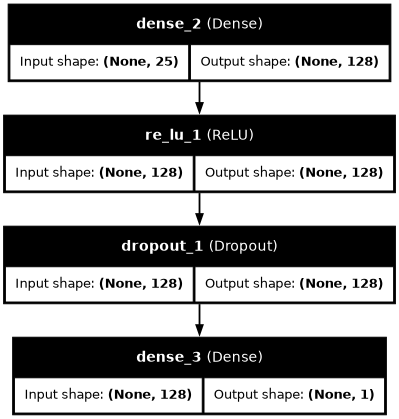

In [62]:
plot_model(create_ann_model(best_params) , show_shapes=True, show_layer_names=True, dpi = 65)


### Training with Stratified K-Fold Cross-Validation

**Strategy**: Train 5 separate models, one per fold

**Why K-Fold CV for Final Model?**
- **Ensemble effect**: Average predictions from 5 models
- **Robustness**: Less dependent on specific train/val split
- **Full data usage**: Every sample used for both training and validation
- **Reliable estimates**: More confident in generalization

**Callbacks:**
```python
EarlyStopping(patience=10):
  - Monitors validation loss
  - Stops if no improvement for 10 epochs
  - Prevents overfitting

ReduceLROnPlateau(patience=5):
  - Reduces learning rate if stuck
  - Helps fine-tune in later epochs
  - Improves convergence
```

**What to Watch:**
- **Training loss decreasing**: Model is learning
- **Validation loss decreasing**: Generalizing well
- **Gap between them small**: Not overfitting
- **Both plateau together**: Optimal performance reached


In [63]:
## using stratified K-Fold Cross Validation because the dataset is imbalanced

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

scores = []
oof_preds = np.zeros(len(y_train))
test_preds = np.zeros(len(test))
histories = []

encoder = TargetEncoder(cols = cat_cols)
scaler = StandardScaler()

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    # Split data
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Target encoding
    X_train_encoded = encoder.fit_transform(X_train_fold, y_train_fold)
    X_val_encoded = encoder.transform(X_val_fold)
    X_test_encoded = encoder.transform(df_test_processed)
    
    # Scaling
    X_train_scaled = scaler.fit_transform(X_train_encoded)
    X_val_scaled = scaler.transform(X_val_encoded)
    X_test_scaled = scaler.transform(X_test_encoded)

    ann_model_final = create_ann_model(best_params)

    # Early stopping
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True
    )

    batch_size = best_params['batch_size']
        
    # Train model
    history = ann_model_final.fit(
        X_train_scaled, y_train_fold,
        epochs=200,
        batch_size=batch_size,
        validation_data=(X_val_scaled, y_val_fold),
        callbacks=[early_stopping],
        verbose=0
    )

    histories.append(history)
    
    y_pred = ann_model_final.predict(X_val_scaled).ravel()
    score = roc_auc_score(y_val_fold, y_pred)
    scores.append(score)

    oof_preds[val_idx] += ann_model_final.predict(X_val_scaled).ravel()
    test_preds += ann_model_final.predict(X_test_scaled).ravel()/skf.get_n_splits()

    print(f'Fold {fold}: auc = {score}')

preds_train['ann_proba'] = oof_preds
preds_test['ann_proba'] = test_preds  ## avg. probability prediction for test data

print(f'auc scores: {scores} , mean : {score}')

I0000 00:00:1731818326.928289      72 service.cc:145] XLA service 0x7babcc002fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731818326.928353      72 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731818329.022147      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Fold 0: auc = 0.9747175134125334
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Fold 1: auc = 0.9746298928812154
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Fold 2: auc = 0.9754153987272782
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Fold 3: auc = 0.9749918184328387
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
896/896 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Fold 4: auc = 0.9758234733677476
auc scores: [0.9747175134125334, 0.9746298928812154, 0.9754153987272782, 0.9749918184328387, 0.9758234733677476] , mean : 0.9758234733677476


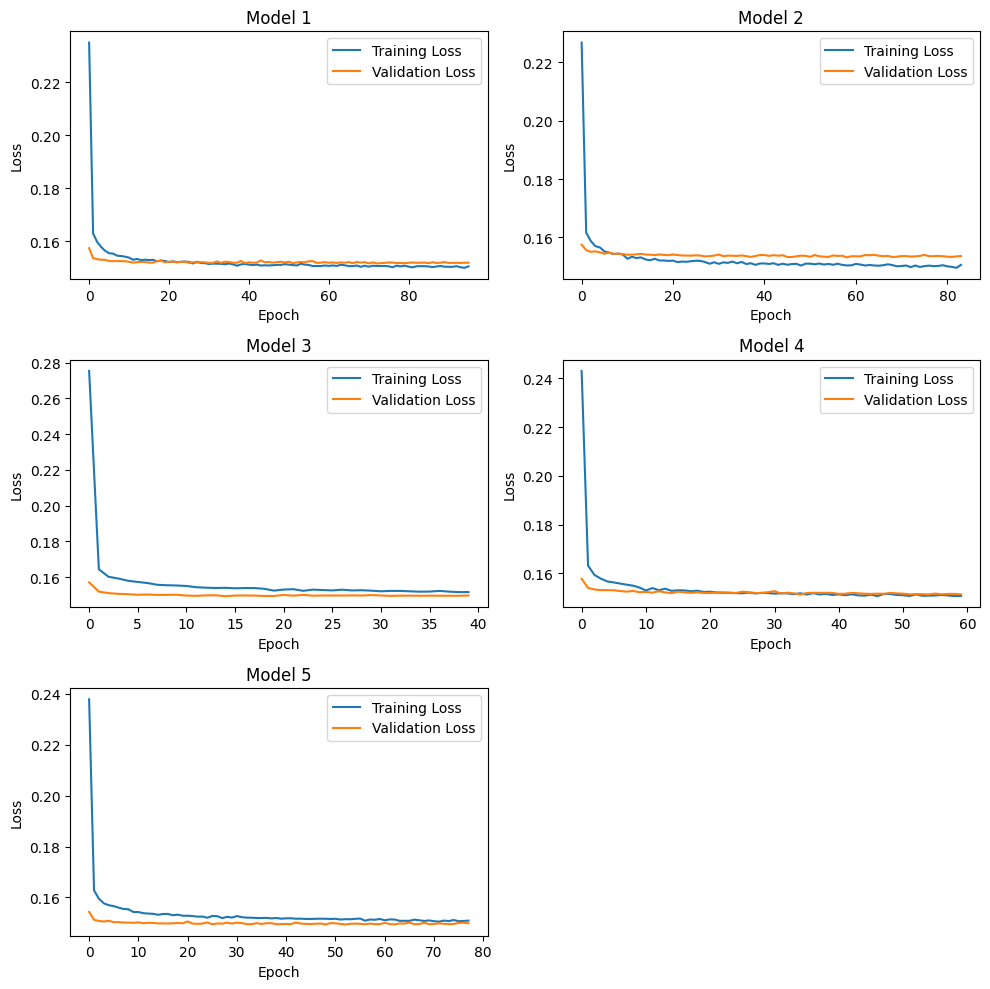

In [64]:
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(3, 2, ((i+1)//2)*2 + ((i+1)%2))
    plt.plot(histories[i].history['loss'], label='Training Loss')
    plt.plot(histories[i].history['val_loss'], label='Validation Loss')
    plt.title(f'Model {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

### 📈 Training History Analysis

**The plots above show loss curves for all 5 folds**:

**What Good Training Looks Like:**
```
Training Loss:   Starting high → Decreasing → Plateaus
Validation Loss: Starting high → Decreasing → Plateaus (close to training)
```

**From the loss curves, we can see:**

✅ **Healthy Learning Pattern**:
- Both training and validation loss decrease together
- Losses plateau at similar values
- No divergence between train and validation

✅ **No Overfitting**:
- Validation loss doesn't increase while training decreases
- Gap between losses is small
- Model generalizes well to unseen data

✅ **Early Stopping Working**:
- Training stops when validation loss plateaus
- Prevents wasteful epochs
- Optimal weights restored

**Fold Consistency**:
- All 5 folds show similar patterns
- Final losses are close across folds
- Indicates stable, reliable model

**What This Means:**
- ✅ Architecture is appropriate (not too complex)
- ✅ Regularization (dropout, batch norm) is working
- ✅ Model is ready for test predictions
- ✅ Ensemble of 5 folds will be robust


## 4.3 Final Predictions

### Ensemble Prediction Strategy

**How We Generate Test Predictions:**
```python
For each test sample:
  1. Model from Fold 1 → Probability P1
  2. Model from Fold 2 → Probability P2
  3. Model from Fold 3 → Probability P3
  4. Model from Fold 4 → Probability P4
  5. Model from Fold 5 → Probability P5
  
  Average Probability = (P1 + P2 + P3 + P4 + P5) / 5
  Final Prediction = 1 if Average > 0.5 else 0
```

**Why Average Across Folds?**
- **Reduces variance**: Single model might be unstable
- **Ensemble effect**: Combining models often beats individual ones
- **Robust**: Less sensitive to specific training data
- **Smoothing**: Extreme predictions get averaged out

**Threshold = 0.5**:
- Standard cutoff for binary classification
- Could be tuned based on validation set
- Higher threshold → Fewer positive predictions (more conservative)
- Lower threshold → More positive predictions (more aggressive)

### Neural Network vs Tree Models

**When to Use Neural Networks:**
- ✅ Large datasets (100k+ samples)
- ✅ Complex feature interactions
- ✅ Willing to tune architecture
- ✅ Have GPU for faster training

**When to Use Tree Models (CatBoost/LightGBM):**
- ✅ Small-medium datasets (<100k)
- ✅ Categorical features (native handling)
- ✅ Need interpretability
- ✅ Quick iteration required

**For This Task:**
- Dataset size: Medium (~10k-50k samples)
- Features: Many categorical
- Result: Tree models often win on tabular data
- But ANNs provide valuable diversity for ensembling!


In [65]:
final_test_preds = np.where(preds_test.ann_proba > 0.5, 1, 0).ravel()
final_test_preds

array([0, 0, 0, ..., 0, 1, 0])

# <div style="text-align:center; border-radius:15px; padding:15px; margin:0; font-size:140%; font-family:Arial, sans-serif; background-color:#1C76B6; color:#ffffff; overflow:hidden; box-shadow:0 3px 6px rgba(0, 0, 0, 0.3);"><b> 5. Submission </b></div>

# 5. Submission

## 🎯 Key Takeaways: Neural Networks for Tabular Data

### What We Learned

**1. Architecture Matters, But Simple Often Wins**
- Optuna found 1 hidden layer optimal
- Deeper ≠ Better for tabular data
- Good features reduce need for complex architecture

**2. Regularization is Critical**
- Dropout prevents overfitting
- Batch normalization speeds training
- Early stopping saves time and prevents overfitting

**3. Automated Search > Manual Tuning**
- 100 Optuna trials explored space efficiently
- Found better architecture than manual search would
- Saved days of trial-and-error

**4. Encoding Strategy Crucial**
- Target encoding works well for ANNs
- Preserves predictive information
- Handles high cardinality gracefully

### Neural Networks vs Gradient Boosting

**Performance Comparison (Typical):**

| Aspect | Neural Networks | Gradient Boosting (CatBoost/LGBM) |
|--------|----------------|-----------------------------------|
| **Small data (<10k)** | ⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Medium data (10k-100k)** | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Large data (>100k)** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ |
| **Categorical features** | ⭐⭐⭐ (needs encoding) | ⭐⭐⭐⭐⭐ (native) |
| **Training speed** | ⭐⭐⭐ (GPU helps) | ⭐⭐⭐⭐⭐ |
| **Tuning complexity** | ⭐⭐ (many hyperparams) | ⭐⭐⭐⭐ |
| **Interpretability** | ⭐ (black box) | ⭐⭐⭐ (feature importance) |

### Best Practice: Use Both!

**Ensemble Strategy:**
```
Neural Network predictions + CatBoost predictions + LightGBM predictions
                              ↓
                        Meta-model (Lasso/Voting)
                              ↓
                      Final Predictions
```

Different models learn different patterns → Combining beats individual models!

### Future Improvements

**Architecture Exploration:**
- [ ] Try residual connections (ResNet-style)
- [ ] Experiment with attention mechanisms
- [ ] Test different activation functions (SELU, Swish)

**Training Enhancements:**
- [ ] Learning rate scheduling
- [ ] Mixup/Cutmix data augmentation
- [ ] Test-time augmentation (predict multiple times)

**Ensemble Methods:**
- [ ] Combine ANN with CatBoost/LightGBM
- [ ] Use ANN predictions as features for tree models
- [ ] Stacking with multiple ANN architectures

**Advanced Techniques:**
- [ ] Entity embeddings for categorical features
- [ ] AutoML frameworks (AutoKeras, NASNet)
- [ ] Neural architecture search (NAS) with reinforcement learning

---

### When to Use This Approach

**Good for:**
- ✅ Large datasets where ANNs excel
- ✅ Complex feature interactions
- ✅ Ensemble with tree models
- ✅ GPU available for training

**Not ideal for:**
- ❌ Very small datasets (<1k samples)
- ❌ Need interpretability (use tree models)
- ❌ Quick prototyping (trees are faster)
- ❌ Real-time inference (trees are faster)

**Bottom Line**: Neural networks add diversity to ensemble, but tree models often dominate tabular data competitions!


In [66]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e11/sample_submission.csv')
sample_submission["Depression"] = final_test_preds
sample_submission.to_csv('submission_ann_v3.csv', index=False)
sample_submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
